# Chapter 5: Decision Trees and Random Forests

#### From Stephen Klosterman's book DATA SCIENCE PROJECTS WITH PYTHON (2019).

<h3>Goals:</h3>
<ul>
    <li>Train a decision tree model in scikit-learn</li>
    <li>Use Graphviz to visualize a trained decision tree model</li>
    <li>Formulate the cost functions used to split nodes in a decision tree</li>
    <li>Perform a hyperparameter grid search using cross-validation with scikit-learn functions</li>
    <li>Train a random forest model in scikit-learn</li>
    <li>Evaluate the most important features in a random forest model</li>
</ul>

In [1]:
import sys
import numpy as np
import pandas as pd
import sklearn
print('The Python version is {}.\n'.format(sys.version))
print('The Scikit-Learn version is {}.\n'.format(sklearn.__version__))

The Python version is 3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)].

The Scikit-Learn version is 0.22.1.



In [2]:
import matplotlib.pyplot as plt 
import matplotlib as mpl 

#Next line helps with rendering plots
%matplotlib inline

mpl.rcParams['figure.dpi'] = 100

In [3]:
#!conda install graphviz
#!conda install python-graphviz

In [4]:
import graphviz #to visualize decision trees

## Import and organize data

In [6]:
df = pd.read_csv('Data/Chapter_1_cleaned_data_OLD.csv')

features_response = df.columns.tolist()

items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

features_response = [item for item in features_response if item not in items_to_remove]

## Train a Decision Tree

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import tree

X_train, X_test, y_train, y_test = \
train_test_split(
    df[features_response[:-1]].values, 
    df['default payment next month'].values,
    test_size=0.2, 
    random_state=24)

dt = tree.DecisionTreeClassifier(max_depth=2)

dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Plot the Decision Tree

#### This saves a .dot file to disk, that could be turned in to an image file

In [8]:
dot_data = tree.export_graphviz(
    dt, 
    out_file=None,
    filled=True, 
    rounded=True,
    feature_names=features_response[:-1],
    proportion=True, 
    class_names=['Not defaulted', 'Defaulted']) 

graph = graphviz.Source(dot_data) 


## Training Decision Trees: Node Impurity

<p>The goal of training decision trees is to make splits so that the next two nodes after the split have a higher <strong>purity</strong>: that is to say, to take them closer to containing either only positive or only negative samples.</p>

<p>The <strong>misclassification rate</strong> is simply the proportion of the less common class in that node, since all these samples will be misclassified when the majority class in that node is taken as the prediction.</p>

<p>The algorithm considers each possible threshold for every candidate features and chooses the one that results in the lowest impurity, calculated as the average impurity across the two possible new nodes, weighted by the number of samples in each node.</p>

<p>The two options that are available in scikit-learn for the impurity calculation, which you can specify with the <strong>criterion</strong> keyword argument, are the <strong>Gini impurity</strong> and the <strong>cross-entropy</strong> options.</p>

<p>Like the misclassification rate, both the Gini impurity and the cross entropy are highest when the class fractions are equal to 0.5, and they decrease as the node becomes purer: in other words, when they contain a higher proportion of just one of the classes.</p>

## Training Decision Trees: A Greedy Algorithm

<p>There is no guarantee that a decision tree trained by the process described previously will be the best possible decision tree for finding leaf nodes with the lowest impurity. This is because the algorithm used to train decision trees is what is called a greedy algorithm. In this context, this means that, at each opportunity to split the node, the algorithm is looking for the best possible split at that point in time, without regard to the fact that the opportunities for later splits are being affected.</p>

<p>The reason why we still use the algorithm is because it takes substantially longer to consider all possible splits in a way that enables finding the truly optimal tree. Despite this shortcoming of the decision tree training process, there are methods that you can use to reduce the possible harmful effects of the greedy algorithm:</p>

<p>Instead of searching for the best split at each node, the <strong>splitter</strong> keyword argument to the decision tree class can be specified as <strong>random</strong> in order to choose a random feature to make a split on. However, the default is <strong>best</strong>, which separates all features for the best split.</p>

<p>Another option is to limit the number of features using the <strong>max_features</strong> keyword, which will be searched at each splitting opportunity.</p>

## Using Decision Trees: Advantages and Predicted Probabilities

In [9]:
from sklearn.datasets import make_circles

X_circ, y_circ = make_circles(n_samples = 300, shuffle=True,
                             noise=0.1, random_state=1, factor=0.4)

[]

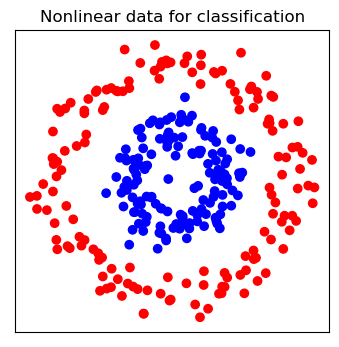

In [10]:
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

ax = plt.axes()
ax.scatter(X_circ[:,0], X_circ[:,1], c=y_circ, cmap=cm_bright)
ax.set_aspect('equal')
ax.set_title('Nonlinear data for classification')
ax.set_xticks([])
ax.set_yticks([])

In [11]:
x_min, x_max = X_circ[:, 0].min() - .5, X_circ[:, 0].max() + .5
y_min, y_max = X_circ[:, 1].min() - .5, X_circ[:, 1].max() + .5
h = 0.02
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

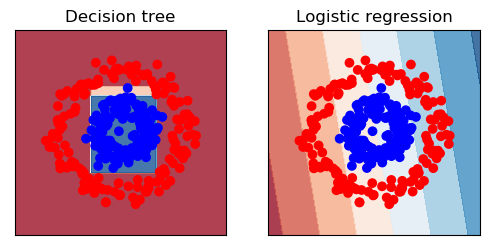

In [12]:
from sklearn.linear_model import LogisticRegression

classifiers = [tree.DecisionTreeClassifier(max_depth=4, random_state=4),
              LogisticRegression()]
titles = ['Decision tree', 'Logistic regression']

counter = 1
for classif in classifiers:
    ax = plt.subplot(1, 2, counter)
    classif.fit(X_circ, y_circ)
    Z = classif.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)
    ax.scatter(X_circ[:,0], X_circ[:,1], c=y_circ, cmap=cm_bright)
    ax.set_aspect('equal')
    ax.set_title(titles[counter-1])
    ax.set_xticks([])
    ax.set_yticks([])
    counter+=1

## Exercise 20: Finding Optimal Hyperparameters for a Decision Tree

In [13]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth':[1, 2, 4, 6, 8, 10, 12]}

cv = GridSearchCV(
    dt, param_grid=params, 
    scoring='roc_auc', 
    n_jobs=None, 
    refit=True, 
    cv=4, 
    verbose=1,
    pre_dispatch=None, 
    error_score=np.nan, 
    return_train_score=True)

cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.3s finished


GridSearchCV(cv=4, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=2,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             pre_

In [14]:
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.015957,0.001222,0.001995,1.032383e-07,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.028677,0.000819,0.001507,4.842342e-04,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.048222,0.006393,0.000745,8.241547e-04,4,{'max_depth': 4},0.732720,0.740116,0.746946,0.743731,0.740878,0.005294,2,0.756882,0.752256,0.749368,0.753055,0.752890,0.002682
3,0.077866,0.005450,0.001995,1.032383e-07,6,{'max_depth': 6},0.744607,0.745757,0.752120,0.741588,0.746018,0.003838,1,0.782202,0.780125,0.775228,0.774776,0.778083,0.003171
4,0.102365,0.008811,0.002244,4.322607e-04,8,{'max_depth': 8},0.728886,0.730574,0.750157,0.732376,0.735498,0.008553,3,0.811837,0.808353,0.803554,0.802046,0.806448,0.003887
5,0.124896,0.003343,0.002244,4.324310e-04,10,{'max_depth': 10},0.709134,0.703213,0.714397,0.710404,0.709287,0.004009,4,0.848949,0.854159,0.841322,0.836819,0.845312,0.006700
6,0.143118,0.003181,0.002251,4.268056e-04,12,{'max_depth': 12},0.672490,0.658266,0.680768,0.684518,0.674011,0.010078,6,0.887891,0.903254,0.885676,0.875499,0.888080,0.009929


In [15]:
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score', 'split0_train_score',
       'split1_train_score', 'split2_train_score', 'split3_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

Text(0, 0.5, 'ROC AUC')

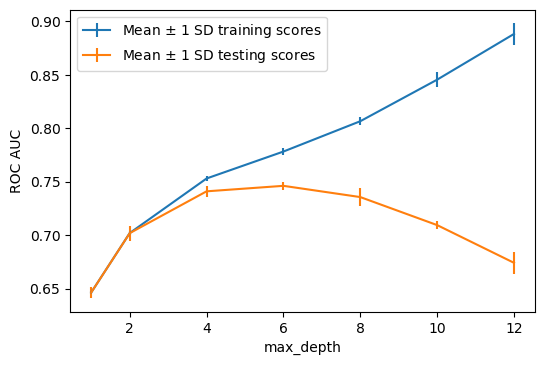

In [16]:
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_train_score'],
            yerr=cv_results_df['std_train_score'],
            label='Mean $\pm$ 1 SD training scores')
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_test_score'],
            yerr=cv_results_df['std_test_score'],
            label='Mean $\pm$ 1 SD testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

In [17]:
cv_results_df.max()

mean_fit_time          0.143118
std_fit_time           0.008811
mean_score_time        0.002251
std_score_time         0.000824
param_max_depth       12.000000
split0_test_score      0.744607
split1_test_score      0.745757
split2_test_score      0.752120
split3_test_score      0.743731
mean_test_score        0.746018
std_test_score         0.010078
rank_test_score        7.000000
split0_train_score     0.887891
split1_train_score     0.903254
split2_train_score     0.885676
split3_train_score     0.875499
mean_train_score       0.888080
std_train_score        0.009929
dtype: float64

## Exercise 21: Fitting a Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10, 
    criterion='gini', 
    max_depth=3,
    min_samples_split=2, 
    min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0,
    max_features='auto', 
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0,
    min_impurity_split=None, 
    bootstrap=True, 
    oob_score=False, 
    n_jobs=None,
    random_state=4, 
    verbose=0, 
    warm_start=False, 
    class_weight=None)

In [20]:
from sklearn.model_selection import GridSearchCV

rf_params_ex = {'n_estimators':list(range(10,110,10))}

cv_rf_ex = GridSearchCV(
    rf, 
    param_grid=rf_params_ex, 
    scoring='roc_auc', 
    n_jobs=None, 
    refit=True, 
    cv=4, 
    verbose=1,
    pre_dispatch=None, 
    error_score=np.nan, 
    return_train_score=True)

cv_rf_ex.fit(X_train, y_train)

cv_rf_ex_results_df = pd.DataFrame(cv_rf_ex.cv_results_)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   18.9s finished


In [21]:
cv_rf_ex_results_df.max()

mean_fit_time           0.745025
std_fit_time            0.020550
mean_score_time         0.027418
std_score_time          0.003964
param_n_estimators    100.000000
split0_test_score       0.748437
split1_test_score       0.755878
split2_test_score       0.779478
split3_test_score       0.773134
mean_test_score         0.763651
std_test_score          0.014656
rank_test_score        10.000000
split0_train_score      0.775419
split1_train_score      0.774025
split2_train_score      0.766133
split3_train_score      0.767032
mean_train_score        0.770550
std_train_score         0.004191
dtype: float64

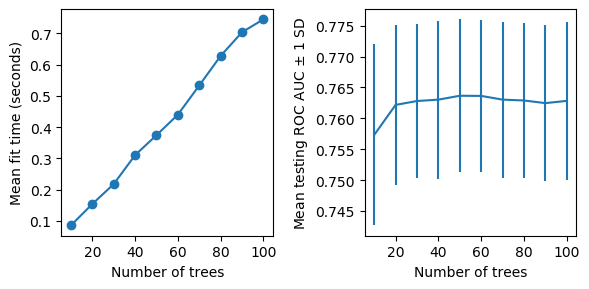

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
axs[0].plot(cv_rf_ex_results_df['param_n_estimators'],
            cv_rf_ex_results_df['mean_fit_time'],
            '-o')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Mean fit time (seconds)')
axs[1].errorbar(cv_rf_ex_results_df['param_n_estimators'],
                cv_rf_ex_results_df['mean_test_score'],
                yerr=cv_rf_ex_results_df['std_test_score'])
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Mean testing ROC AUC $\pm$ 1 SD ')
plt.tight_layout()

In [23]:
cv_rf_ex.best_params_

{'n_estimators': 50}

In [24]:
feat_imp_df = pd.DataFrame({
    'Feature name':features_response[:-1],
    'Importance':cv_rf_ex.best_estimator_.feature_importances_
})

feat_imp_df.sort_values('Importance', ascending=False)

,Feature name,Importance
4,PAY_1,0.609609
11,PAY_AMT1,0.094123
0,LIMIT_BAL,0.079265
13,PAY_AMT3,0.047067
12,PAY_AMT2,0.035393
6,BILL_AMT2,0.022422
14,PAY_AMT4,0.021164
15,PAY_AMT5,0.015962
10,BILL_AMT6,0.014293
8,BILL_AMT4,0.013454
